In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import transformers
from transformers import AutoModel
import sys
import math
import seaborn as sb
import matplotlib.pyplot as plt
sys.path.insert(0,'..')

from utils.preprocessing import load_data
from utils.transformer_dataset import ReviewDataset
from utils.training import train_text_model, train_text_meta_model, train_meta_model
from models.transformer_models import UsefulScoreRegressorTextOnly, UsefulScoreRegressorAllFeat, UsefulScoreRegressorMetaOnly

In [2]:
# Load data
train, val = load_data('../data/drugsComTrain_raw.csv')

In [4]:
train.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'cleanReview', 'usefulScore', 'ratingNormalized',
       'daysOld', 'ageScore', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
       'Birth Control', 'Depression', 'Insomnia', 'Obesity', 'Pain',
       'Weight Loss'],
      dtype='object')

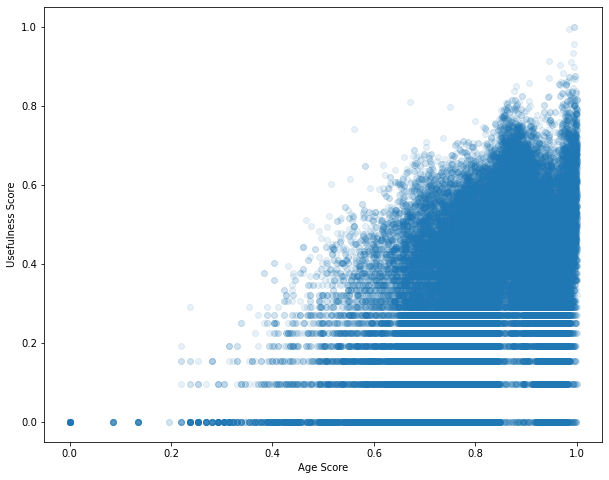

In [16]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulScore, alpha=0.1)
ax.set_ylabel('Usefulness Score')
ax.set_xlabel('Age Score')

plt.show()

The above plot shows all our data with the logged age score and logged usefulness score. The distribution is not as even as the ones discussed below.

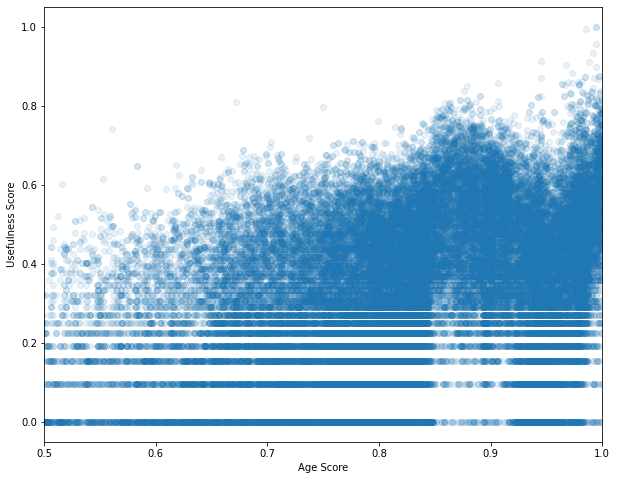

In [18]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulScore, alpha=0.1)
ax.set_ylabel('Usefulness Score')
ax.set_xlabel('Age Score')
ax.set_xlim([0.5, 1])

plt.show()

The above plot shows the distribution of usefulness score by age score for only the older half of the reviews. However, the distribution is still not very even.

Better to train and evaluate the model on older reviews (e.g., 0.5 to 1) because young reviews have not had time for their usefulness to reach its steady-state yet. Even better may be to only consider older reviews and not use the age of the review as a feature. 

In [31]:
train.date.dt.year.value_counts(normalize=True).sort_index()

2008    0.026991
2009    0.066801
2010    0.052359
2011    0.076087
2012    0.064638
2013    0.076592
2014    0.076754
2015    0.173972
2016    0.214413
2017    0.171394
Name: date, dtype: float64

To improve the model training and validation, only consider reviews from 2008 to 2011.

In [2]:
#### Load data with year range from 2008 to 2011
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2011])

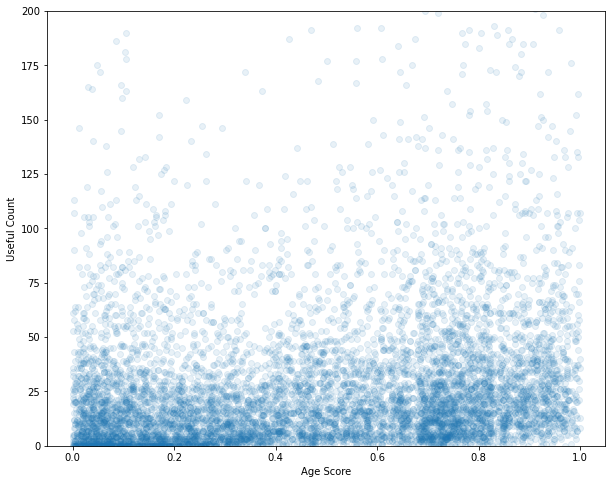

In [3]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCount, alpha=0.1)
ax.set_ylabel('Useful Count')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 200])

plt.show()

As shown above, removing usefulness outliers gives a more even distribution of usefulness than taking logs. Our chosen date range will thus be 2009 to 2011

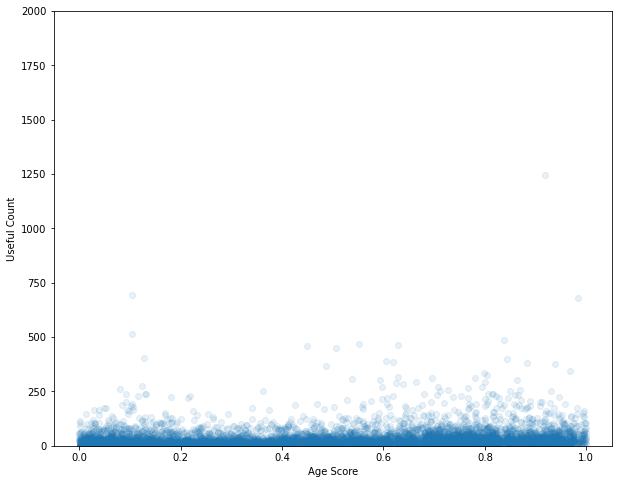

In [4]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCount, alpha=0.1)
ax.set_ylabel('Useful Count')
ax.set_xlabel('Age Score')
#ax.set_xlim([0, 1])
ax.set_ylim([0, 2000])

plt.show()

As shown, most of the mass is between 0 and 250 in terms of the usefulCount, with some outliers above. In order to help the model, we could consider capping these outliers to a maximum usefulCountCapped of 250

Next, we will explore some of the specific reviews at different levels of usefulness. It will be interesting to look at some of the highly useful outlier reviews, to try and see what makes them qualitatively different from other useful reviews that are not outliers.

In [5]:
train.loc[train['usefulCount'] >= 700]

uniqueID drugName      condition  \
4249    182560   Mirena  Birth Control   

                                                 review  rating       date  \
4249  "I have had my IUD for over a year now and I t...      10 2009-04-01   

      usefulCount                                        cleanReview  \
4249         1247  I have had my IUD for over a year now and I th...   

      usefulScoreLog  usefulCountCapped  ...  ADHD  Acne  Anxiety  \
4249             1.0               1247  ...     0     0        0   

      Bipolar Disorde  Birth Control  Depression  High Blood Pressure  \
4249                0              1           0                    0   

      Insomnia  Pain  ibromyalgia  
4249         0     0            0  

[1 rows x 23 columns]

In [6]:
train.loc[train['usefulCount']==max(train['usefulCount']), 'cleanReview'].item()

"I have had my IUD for over a year now and I think it's the best thing ever. When I first got it put in I only bled for about a week with a little cramping. After that nothing at all. I haven't had a period for about 8months until I finally got one, and its not bad at all. It's light, no cramping, no headache, nothing. I haven't gained weight, my acne is gone, and my moods are fine. I know all women are different, but I just hear all these horror stories and I just wanted to tell my story, which is a good one. Hope it calms some of your fears."

In [7]:
print(train.loc[train['usefulCount'] == 200, 'daysOld'].item())
print(train.loc[train['usefulCount'] == 200, 'rating'].item())
print(train.loc[train['usefulCount'] == 200, 'condition'].item())
print(train.loc[train['usefulCount'] == 200, 'drugName'].item())
print(train.loc[train['usefulCount'] == 200, 'cleanReview'].item())

760.0
4
ADHD
Lisdexamfetamine
My 8 year old son has been on this mediation for 1 year and a half. He started at 20mg now he is taking 40mg. I have noticed that it does not seem to work and after trying for 9 months to get him off and on something else I am going to take him to a different doctor. Given the fact that after 9 months it is still not working another doctor would try something different but his Doctor just keeps upping the dosage. I have also noticed side effects that disturb. It worries me because my son is usually happy go lucky all the time and with this medicine he is VERY EASILY upset, not himself at all. SO PLEASE BE AWARE OF EVERYTHING YOUR CHILD DOES OR ACTS WHILE TAKING THIS MEDICATION.


In [8]:
print(train.loc[train['usefulCount'] == 0, 'daysOld'].iloc[0])
print(train.loc[train['usefulCount'] == 0, 'rating'].iloc[0])
print(train.loc[train['usefulCount'] == 0, 'condition'].iloc[0])
print(train.loc[train['usefulCount'] == 0, 'drugName'].iloc[0])
train.loc[train['usefulCount'] == 0, 'cleanReview'].iloc[0]

178.0
10
Birth Control
Ethinyl estradiol / norethindrone


"I'm in the middle of my second week with my first pack. No side effects whatsoever. No weight gain, no mood swings, no nothing which I think is amazing. This is my first time being on birth control and I would definitely recommend Loestrin. "

In [9]:
print(train.loc[train['usefulCount'] == 0, 'daysOld'].iloc[8])
print(train.loc[train['usefulCount'] == 0, 'rating'].iloc[8])
print(train.loc[train['usefulCount'] == 0, 'condition'].iloc[8])
print(train.loc[train['usefulCount'] == 0, 'drugName'].iloc[8])
train.loc[train['usefulCount'] == 0, 'cleanReview'].iloc[8]

258.0
4
Birth Control
Sprintec


"I've been on this for a week and it's caused me to be more moody and nauseous pretty bad the first few days. On the 3 day it subsided momentarily then came back on the 4th day. It's pretty much off and on, not unbearable but makes me have less of an appetite. Get dull cramps daily and was worried about it until I read these other posts. My breasts are also sore and sex drive has decreased a little.  Also been tired before it even hits 9p.m. Makes my work day longer. "

In [10]:
print(train.loc[train['usefulCount'] == 0, 'daysOld'].iloc[19])
print(train.loc[train['usefulCount'] == 0, 'rating'].iloc[19])
print(train.loc[train['usefulCount'] == 0, 'condition'].iloc[19])
print(train.loc[train['usefulCount'] == 0, 'drugName'].iloc[19])
train.loc[train['usefulCount'] == 0, 'cleanReview'].iloc[19]

124.0
10
Birth Control
Etonogestrel


"I have Implanon for about 5 months, no bleeding, only spotting. I had my period only once. I don't have any mood swings, I am more relaxed, no PMS. Sometimes light headache, but goes away in few minutes. It doesn't cost me any trouble and save on pads (usually used all package heavy ones and half package light ones). So far no problem."

In [11]:
print(train.loc[train['usefulCount'] == 100, 'daysOld'].iloc[0])
print(train.loc[train['usefulCount'] == 100, 'rating'].iloc[0])
print(train.loc[train['usefulCount'] == 100, 'condition'].iloc[0])
print(train.loc[train['usefulCount'] == 100, 'drugName'].iloc[0])
train.loc[train['usefulCount'] == 100, 'cleanReview'].iloc[0]

740.0
10
ibromyalgia
Topiramate


"It's a wonder drug - my daughter takes it and lost so much weight. Her headache's are gone, she feels like a million bucks."

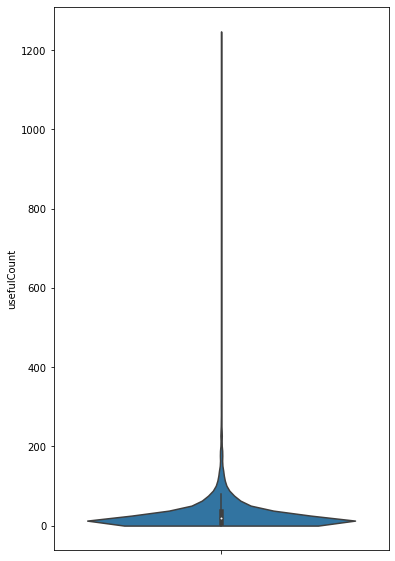

In [12]:
### Work on capping the usefulCount to better handle outliers
fig, ax = plt.subplots(figsize=(6, 10))
sb.violinplot(y=train['usefulCount'], cut=0)
plt.show()

#### Usefulness of reviews by condition

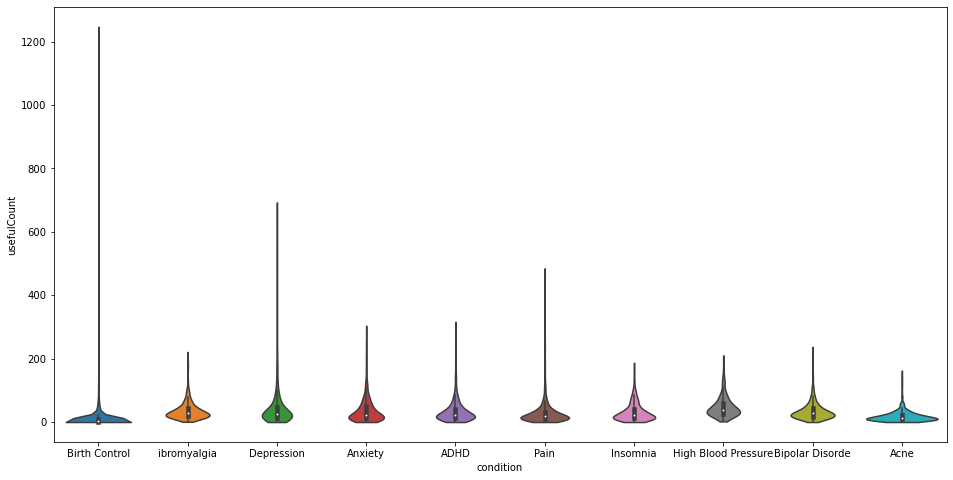

In [13]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2011], usefulCount_range=[0, 10000])

fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['condition'], y=train['usefulCount'], cut=0)
plt.show()

#### Usefulness by condition

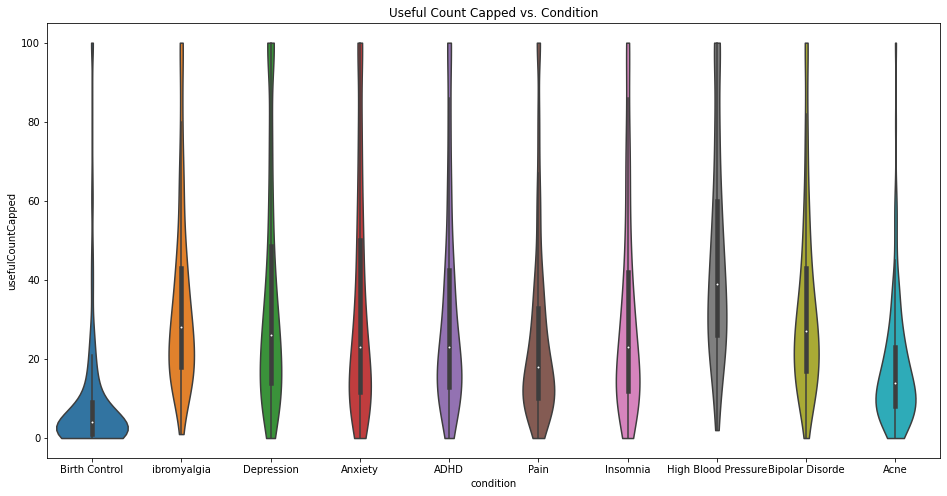

In [21]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2011], usefulCount_range=[0, 100])

fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['condition'], y=train['usefulCountCapped'], cut=0)
plt.title('Useful Count Capped vs. Condition')
plt.show()

Note that the distribution of usefulness scores are somewhat similar across condition, but different for birth control.

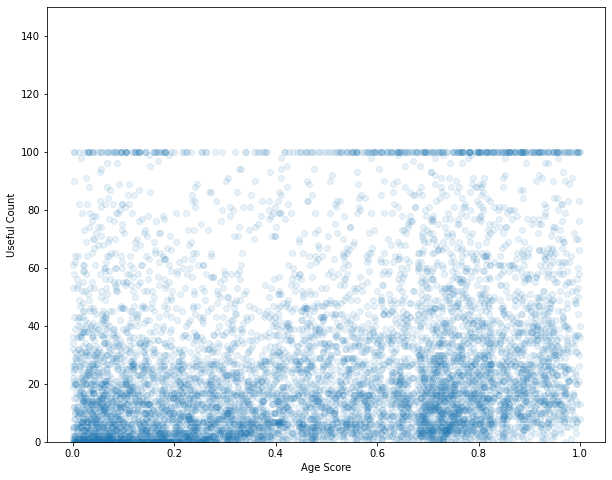

In [15]:
# Create scatter plots between age score and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCountCapped, alpha=0.1)
ax.set_ylabel('Useful Count')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 150])

plt.show()

In [16]:
# Check count of reviews by condition
train['condition'].value_counts()

Birth Control          1836
Pain                   1387
Depression             1115
Anxiety                 684
Bipolar Disorde         482
ADHD                    475
Insomnia                469
High Blood Pressure     461
Acne                    409
ibromyalgia             359
Name: condition, dtype: int64

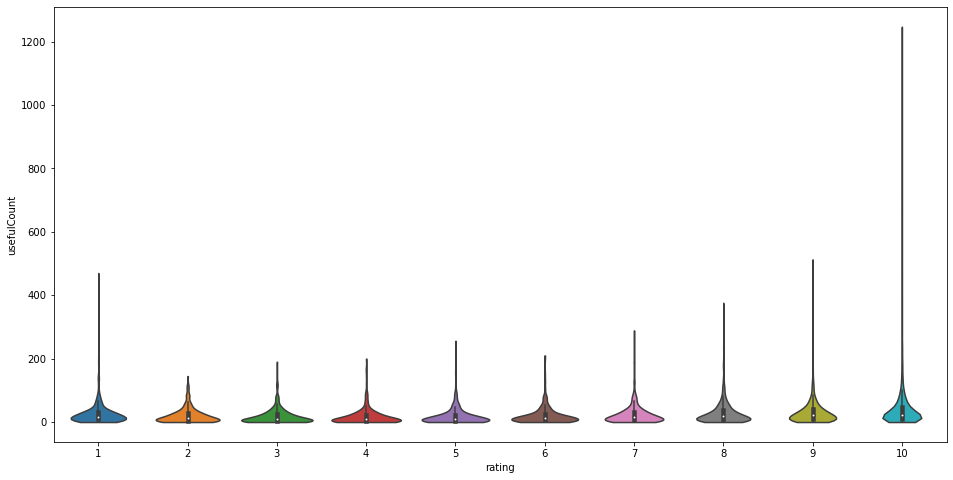

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['rating'], y=train['usefulCount'], cut=0)
plt.show()

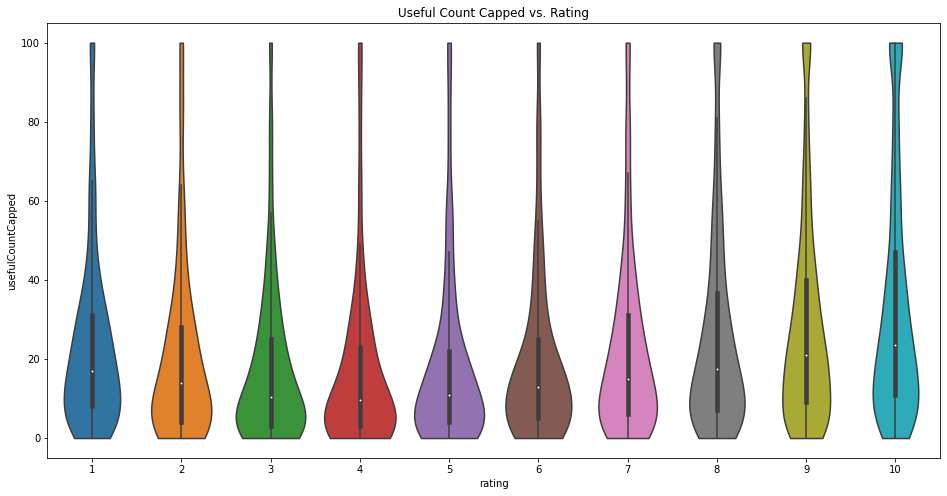

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['rating'], y=train['usefulCountCapped'], cut=0)
plt.title('Useful Count Capped vs. Rating')
plt.show()

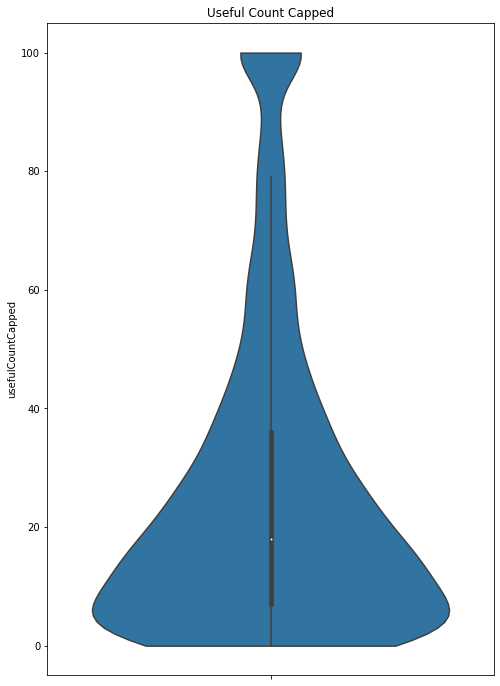

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))
sb.violinplot(y=train['usefulCountCapped'], cut=0)
plt.title('Useful Count Capped')
plt.show()

In [24]:
len(train)

7677

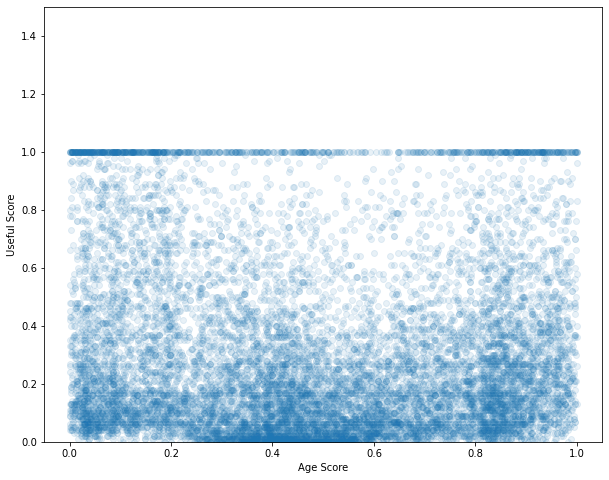

In [3]:
### Try including more years to increase the number of reviews
# Create scatter plots between age score and target variable
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 100])

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCountCappedNormalized, alpha=0.1)
ax.set_ylabel('Useful Score')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 1.5])

plt.show()

In [4]:
len(train)

12924

#### Train RoBERTa model with updated data

In [11]:
##### Create pytorch dataset
nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

##### Text-only Transformer Model
encoder = AutoModel.from_pretrained('roberta-base', return_dict=True)

# Freeze encoder parameters to avoid CUDA out of memory.
for param in encoder.parameters():
    param.requires_grad = False

model = UsefulScoreRegressorTextOnly(encoder)
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_text_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/RoBERTa_Frozen_TextOnly_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00772, train loss: 0.00928
Epoch 1, val loss: 0.00878, train loss: 0.00830
Epoch 2, val loss: 0.00772 -> 0.00734, train loss: 0.00817
Epoch 3, val loss: 0.00734 -> 0.00726, train loss: 0.00802
Epoch 4, val loss: 0.00754, train loss: 0.00806
Epoch 5, val loss: 0.00739, train loss: 0.00806
Epoch 6, val loss: 0.00726 -> 0.00719, train loss: 0.00799
Epoch 7, val loss: 0.00762, train loss: 0.00797
Epoch 8, val loss: 0.00719 -> 0.00718, train loss: 0.00791
Epoch 9, val loss: 0.00718, train loss: 0.00797


#### Metadata-Only Model

In [12]:
##### Create pytorch dataset
nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

model = UsefulScoreRegressorMetaOnly(num_meta_feats=len(nonTextCols))
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/RoBERTa_MetaOnly_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00747, train loss: 0.00814
Epoch 1, val loss: 0.00747 -> 0.00740, train loss: 0.00752
Epoch 2, val loss: 0.00746, train loss: 0.00746
Epoch 3, val loss: 0.00741, train loss: 0.00742
Epoch 4, val loss: 0.00740 -> 0.00733, train loss: 0.00739
Epoch 5, val loss: 0.00733, train loss: 0.00737
Epoch 6, val loss: 0.00740, train loss: 0.00731
Epoch 7, val loss: 0.00733, train loss: 0.00732
Epoch 8, val loss: 0.00733 -> 0.00729, train loss: 0.00732
Epoch 9, val loss: 0.00731, train loss: 0.00729


#### Combined Text and Metadata Model

In [13]:
##### Create pytorch dataset
nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

##### Text-only Transformer Model
encoder = AutoModel.from_pretrained('roberta-base', return_dict=True)

# Freeze encoder parameters to avoid CUDA out of memory.
for param in encoder.parameters():
    param.requires_grad = False

model = UsefulScoreRegressorAllFeat(encoder, num_meta_feats=len(nonTextCols))
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_text_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                      train_loader=train_loader, val_loader=val_loader,
                      criterion=criterion, save_path='../models/RoBERTa_Frozen_TextMeta_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00754, train loss: 0.00831
Epoch 1, val loss: 0.00754 -> 0.00719, train loss: 0.00750
Epoch 2, val loss: 0.00719 -> 0.00700, train loss: 0.00736
Epoch 3, val loss: 0.00700 -> 0.00680, train loss: 0.00742
Epoch 4, val loss: 0.00704, train loss: 0.00730
Epoch 5, val loss: 0.00698, train loss: 0.00725
Epoch 6, val loss: 0.00692, train loss: 0.00712
Epoch 7, val loss: 0.00680 -> 0.00670, train loss: 0.00714
Epoch 8, val loss: 0.00670, train loss: 0.00716
Epoch 9, val loss: 0.00670 -> 0.00669, train loss: 0.00717
